In [1]:
import pandas as pd
import numpy as np
import math
import time
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import v_measure_score, homogeneity_score, completeness_score, rand_score, accuracy_score, precision_score, f1_score, adjusted_rand_score
from minisom import MiniSom
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from tribus import run_tribus
from visualization import heatmap_for_median_expression, marker_expression, umap_vis, z_score, cell_type_distribution
from sklearn.metrics import confusion_matrix
from matplotlib.patches import Patch

In [2]:
def train_som(x, y, input_len, sigma, learning_rate, iterations, marker_data): 
    # a function to call minisom easily.

    som = MiniSom(x=x, 
                  y=y, 
                  input_len = input_len, 
                  sigma = sigma, 
                  learning_rate = learning_rate, 
                  neighborhood_function='gaussian')
    som.random_weights_init(marker_data)
    # training
    start_time = time.time()
    som.train_random(marker_data, iterations)
    elapsed_time = time.time() - start_time
    print(elapsed_time, " seconds")
    return som

def cell_num_compare(true_label, pred_label): 
    # Plot barplots that show cell numbers in each type, compare with ground truth. 

    Tribus_stat = pd.DataFrame(np.array(np.unique(pred_label, return_counts=True)).T, columns=("Cell_type", "Tribus"))
    Truth_stat = pd.DataFrame(np.array(np.unique(true_label, return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
    Stat_merged = pd.merge(Tribus_stat, Truth_stat, how="outer", on=["Cell_type"])
    Stat_merged["Tribus"] = pd.to_numeric(Stat_merged["Tribus"])
    Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])

    Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)
    plt.show()


def get_subsets(sample_file, labels):
    # copied from Tribus. 

    cell_types = np.unique(labels)
    new_file = sample_file.copy()
    new_file.loc[:, 'labels'] = labels
    subsets = []
    normal_cell_types = []
    for cell_type in cell_types:
        if "undefined" in cell_type or "other" in cell_type:
            continue
        else:
            subsets.append(new_file.loc[new_file['labels'] == cell_type])
            normal_cell_types.append(cell_type)
    return subsets, normal_cell_types

def my_confusion_matrix(true_label, pred_label): 
    # Plot confusion matrix. 

    celltype_true = np.array(true_label).tolist()
    celltype_pred = np.array(pred_label).tolist()
    cm_labels = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus %')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def cluster_metrics_overall(celltype_true, celltype_pred): 
    # Calculate average accuracy metrics and visualization with barplot

    RI_avg = rand_score(celltype_true, celltype_pred) #between 0-1
    AS_avg = accuracy_score(celltype_true, celltype_pred)
    PS_avg = precision_score(celltype_true, celltype_pred, average='weighted')
    F1_avg = f1_score(celltype_true, celltype_pred, average="weighted")
    print("Rand score = {}, Accuracy score = {}, Precision score = {}, F1 score = {}".format(RI_avg, AS_avg, PS_avg, F1_avg))
    df = pd.DataFrame([RI_avg, AS_avg, PS_avg, F1_avg], columns=['Value'], 
                    index = ["Rand Index", "Accuracy Score", "Precision Score", "F1 Score"])

    colors = {"Rand Index": 'slateblue', "Accuracy Score": 'lightcoral', "Precision Score": 'firebrick', "F1 Score":'steelblue'}
    df.plot.bar(y='Value', width = 0.8, legend=False, 
                color=['slateblue', 'lightcoral', 'firebrick', 'steelblue'], rot=0, xticks=[])
    metric_labels = ["Rand Index", "Accuracy Score", "Precision Score", "F1 Score"]
    handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in metric_labels]
    plt.legend(handles, metric_labels)
    plt.show()

def cluster_metrics_percelltype(celltype_true, celltype_pred): 
    # accuracy metrics per cell type

    classes = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))
    stats_array = metrics.multilabel_confusion_matrix(celltype_true, celltype_pred, labels=classes)
    stats_df = pd.DataFrame()
    for i in range(len(stats_array)):
        stats_df = pd.concat([stats_df, pd.DataFrame(stats_array[i].flatten()).T])
    stats_df.columns = ["TN", "FP", "FN", "TP"]
    stats_df.index = [classes]
    stats_df["accuracy"] = (stats_df["TN"] + stats_df["TP"]) / (stats_df["TN"] + stats_df["TP"] + stats_df["FN"] + stats_df["FP"]) # in celesta paper they use this way to calculate Rand Index
    print(stats_df)
    report = metrics.classification_report(celltype_true, celltype_pred, labels=classes, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(report_df)

    # Support is the number of actual occurrences of the class in the specified dataset.
    rows = math.ceil(len(np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))) / 4)
    fig, ax = plt.subplots(rows, 4, figsize=(15,7))

    for i in range(len(np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true)))): 
        
        celltype = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))[i]
        df = report_df.loc[celltype]
        df["accuracy"] = stats_df.iloc[i,-1].tolist()
        df = df[["precision", "recall", "f1-score", "accuracy"]]
        
        colors = {"Precision Score": 'firebrick', "Recall Score": 'lightcoral', "F1 Score":'rosybrown', "accuracy": 'darksalmon'}
        df.plot.bar(y='Value', ax=ax[int(i / 4)][i % 4], width = 0.85, 
                    title="{}".format(celltype), legend=False, 
                    color=['firebrick', 'lightcoral', 'rosybrown', 'darksalmon'], rot=0, xticks=[])

    metric_labels = ["Precision Score", "Recall Score", "F1 Score", "accuracy"]
    handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in metric_labels]
    plt.legend(handles, metric_labels)
    plt.show()

# Read in datasets

In [28]:
sample_data = pd.read_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\Pre&Post\\input_data\\sample10_filtered2.csv")
print("Data dimension is {}".format(np.shape(sample_data)))

Data dimension is (604539, 44)


In [29]:
df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\Pre&Post\\best_sample10.xlsx")
logic = pd.read_excel(df, df.sheet_names, index_col=0)
cols = ["CD11c", "CD1c", "CD4", "CD3d", "CD20", "CD163", "CD57", "CD8a", "cCasp3", "pSTAT1", "CD15", "Ki67", 
        "PD-L1", "IBA1", "FOXP3", "PD1", "E-cadherin", "Vimentin", "CD31", "P21", "CK7", "CD45"]

In [30]:
sample_data[cols] = z_score(np.log(sample_data[cols]+1))

Q = 0.999
Q = sample_data[cols].quantile(Q)
sample_data = sample_data[~((sample_data[cols] > Q)).any(axis=1)]
print("Removing the outliers. Curent data dimension is {}".format(np.shape(sample_data)))

Removing the outliers. Curent data dimension is (593601, 44)


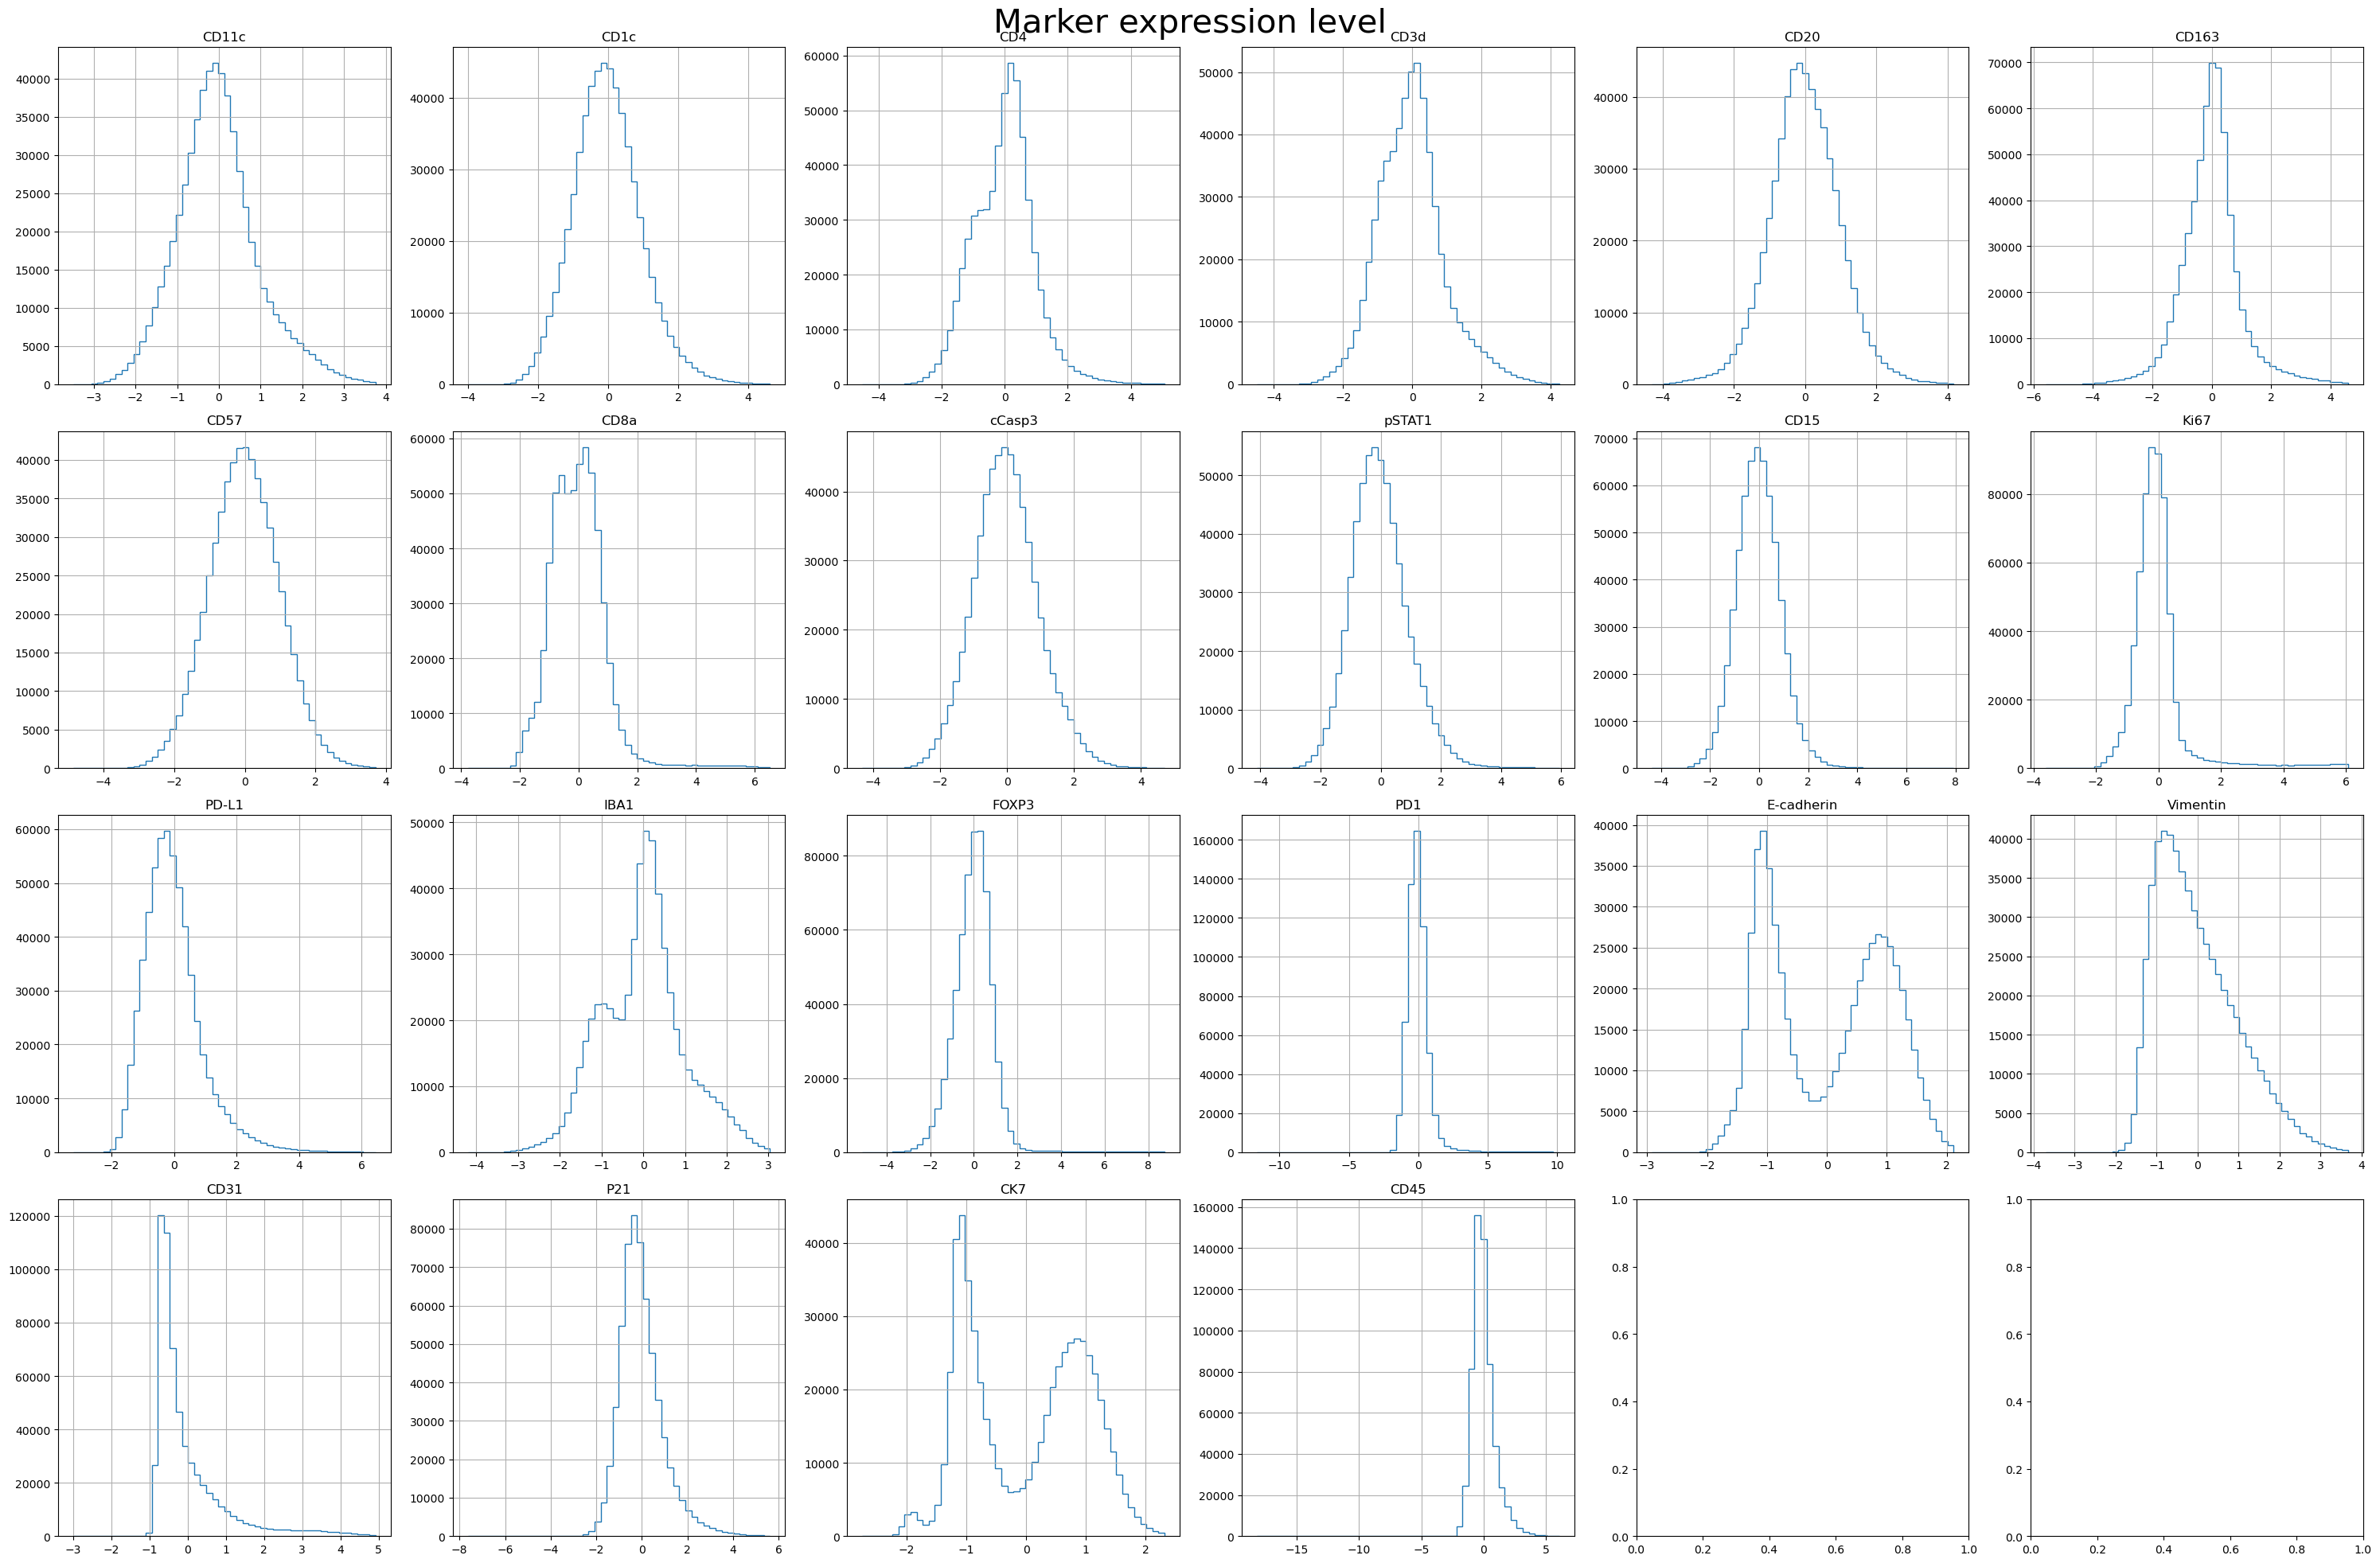

In [31]:
marker_expression(sample_data[cols], markers=None, save=False, fname=None, dpi='figure', log=False)

In [32]:
sample_data[cols].describe()

,CD11c,CD1c,CD4,CD3d,CD20,CD163,CD57,CD8a,cCasp3,pSTAT1,...,PD-L1,IBA1,FOXP3,PD1,E-cadherin,Vimentin,CD31,P21,CK7,CD45
count,593601.000000,593601.000000,593601.000000,593601.000000,593601.000000,593601.000000,593601.000000,593601.000000,593601.000000,593601.000000,...,593601.000000,593601.000000,593601.000000,593601.000000,593601.000000,593601.000000,593601.000000,593601.000000,593601.000000,593601.000000
mean,-0.019759,-0.021338,-0.026680,-0.024218,-0.012539,-0.016883,-0.012921,-0.018901,-0.017328,-0.024112,...,-0.026634,-0.012114,-0.017436,-0.032743,-0.001603,-0.017401,-0.017189,-0.013019,-0.001700,-0.025634
std,0.979108,0.967336,0.959406,0.967458,0.982638,0.979106,0.985773,0.959018,0.972217,0.957157,...,0.935900,0.991904,0.941435,0.874786,0.999304,0.983711,0.978030,0.970747,0.998708,0.918731
min,-3.490500,-4.010168,-4.519944,-4.496242,-4.319801,-5.579180,-4.863704,-3.776153,-4.329002,-4.118114,...,-3.223458,-4.206427,-5.118372,-11.623671,-2.928685,-3.701246,-2.995405,-7.637210,-2.742525,-18.181949
25%,-0.647644,-0.672325,-0.690817,-0.675456,-0.626602,-0.555244,-0.677379,-0.656243,-0.666996,-0.666757,...,-0.654940,-0.710499,-0.543498,-0.523152,-0.984590,-0.792025,-0.621509,-0.641562,-0.986215,-0.606823
50%,-0.082357,-0.067518,0.026536,-0.058206,-0.033562,-0.008214,-0.023279,-0.059245,-0.056325,-0.100108,...,-0.156942,0.026245,0.010286,-0.120081,0.120851,-0.211817,-0.393219,-0.161230,0.164879,-0.170796
75%,0.506478,0.568130,0.535825,0.487359,0.609085,0.445993,0.645843,0.481722,0.583465,0.530405,...,0.419014,0.536618,0.488094,0.306869,0.898904,0.603376,0.203048,0.454705,0.876207,0.386004
max,3.748589,4.617792,5.071310,4.242982,4.173446,4.592547,3.701842,6.523298,4.701497,5.927224,...,6.444057,3.035182,8.742717,10.137752,2.113513,3.668903,4.917022,5.618513,2.312997,6.038677


In [33]:
marker_data = np.arcsinh(sample_data[cols]).to_numpy()

# Run minisom with initial sigma and learning rate

In [34]:
# Initialization and training
grid_size = int(np.sqrt(np.sqrt(len(sample_data)) * 5))
print("The grid size for miniSOM is {}".format(grid_size))

som_shape = (grid_size, grid_size)
som = MiniSom(som_shape[0], som_shape[1], marker_data.shape[1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian')

som.train_batch(marker_data, 500, verbose=True)
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in marker_data]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)
print("Number of clusters generated: {}".format(len(np.unique(cluster_index))))

The grid size for miniSOM is 62
 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 2.0759402765463864
Number of clusters generated: 2779


# Hyperparameter tuning

In [26]:
# set hyperparameters
rows_data = marker_data.shape[0]
x = int(np.sqrt(5 * np.sqrt(rows_data)))
print("x is {}".format(x))
y = x
input_len = marker_data.shape[1]
sigma = 0.003
learning_rate = 5
iterations = 100
max_evals = 5

space = {
    'sig': hp.uniform("sig", 0.001, 5), 
    'learning_rate': hp.uniform("learning_rate", 0.001, 5),
}

def som_fn(space): 
    sig = space['sig']
    learning_rate = space['learning_rate']
    val = MiniSom(x=x, 
                  y=x, 
                  input_len=input_len,
                  sigma=sig,
                  learning_rate=learning_rate
                  ).quantization_error(marker_data)
    print("Current quantization error is {}".format(val))
    return{'loss': val, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn = som_fn, 
            space=space, 
            algo = tpe.suggest, 
            max_evals=max_evals, 
            trials=trials)

print('best: {}'.format(best))

x is 63
Current quantization error is 1.5272109006216052     
Current quantization error is 1.5300268830660082                                
Current quantization error is 1.5492533296495417                                
Current quantization error is 1.5320219541012086                                
Current quantization error is 1.5266387603529916                                
100%|██████████| 5/5 [24:23<00:00, 292.73s/trial, best loss: 1.5266387603529916]
best: {'learning_rate': 2.50456006777247, 'sig': 4.2913261039935735}


In [37]:
sigma = best['sig']
learning_rate = best['learning_rate']
print("Current grid size x is {}, grid size y is {}, sigma is {}, learning rate is {}.".format(x, y, sigma, learning_rate))

Current grid size x is 63, grid size y is 63, sigma is 4.2913261039935735, learning rate is 2.50456006777247.


In [38]:
som = MiniSom(x, y, input_len, sigma=sigma, learning_rate=learning_rate,
              neighborhood_function='gaussian')
som.train_batch(marker_data, 500, verbose=True)

# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in marker_data]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
som_shape = (grid_size, grid_size)
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

print("Number of clusters generated: {}".format(len(np.unique(cluster_index))))

 [ 500 / 500 ] 100% - 0:00:00 left 

c:\Users\Localadmin_kangzigi\.conda\envs\tribus_new\lib\site-packages\minisom.py:536: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)



 quantization error: 1.358411645836816
Number of clusters generated: 1835


# Annotate clusters (copy scoring functions from Tribus)

In [23]:
# All cpoied from Tribus.

MAX_PERCENTILE = 99 

def score_marker_pos(x):
    """
    get the largest value for a marker, subtract from it all the values --> take the squared
    large values will get small values, small values get larger values
    """
    res = [(np.percentile(x, MAX_PERCENTILE) - i) ** 2 for i in x]
    return res


def score_marker_neg(x):
    """
    substrach the minimum from each value --> take the squared
    large values remain large, small values became smaller
    """
    res = [(i - np.min(x)) ** 2 for i in x]
    return res


def normalize_scores(x):
    """
    normalize the values between 0-1
    change the direction of scoring, smaller ones becomes the larger ones and vica versa (inverting)
    """
    if np.max(x) - np.min(x) == 0:
        print(x)

    res = 1 - ((x - np.min(x)) / (np.max(x) - np.min(x)))
    return res


def score_nodes(data_to_score, logic, level):
    """
    scoring function for the clusters, which cluster belong to which cell-type
    data_to_score: dataframe
    logic: dictionary of dataframes
    level: string
    returns: dataframe
    """
    level_logic_df = logic[level]
    scores_matrix = np.zeros((data_to_score.shape[0], logic[level].shape[1]))
    for idx, cell_type in enumerate(logic[level].columns.values):
        list_negative = list(
            level_logic_df.loc[level_logic_df[cell_type] == -1].index)  # get markers with negative scores
        list_positive = list(
            level_logic_df.loc[level_logic_df[cell_type] == 1].index)  # get markers with positive scores

        if list_positive == 0:
            continue

        gating_positive = data_to_score[list_positive].to_numpy()  # rows: clusters, columns: positive markers
        marker_scores_positive = np.apply_along_axis(score_marker_pos, 0, gating_positive)

        if len(list_negative) != 0:
            gating_negative = data_to_score[list_negative].to_numpy()
            marker_scores_negative = np.apply_along_axis(score_marker_neg, 0, gating_negative)

            marker_scores = np.column_stack((marker_scores_positive, marker_scores_negative))
        else:
            marker_scores = marker_scores_positive

        normalized_marker_scores = np.apply_along_axis(normalize_scores, 0, marker_scores)
        scores_matrix[:, idx] = np.mean(normalized_marker_scores, 1) # put the mean of the marker values of a celltype into a matrix (indexed by the celltypes)
    scores_pd = pd.DataFrame(scores_matrix, columns=logic[level].columns.values, index=data_to_score.index)
    return scores_pd

def get_cell_type(x, level, undefined_threshold, other_threshold):
    '''
    assigning cell type based on the score, write "other" if highest score is too low, write "undifined" if the two highest score are too close to eachother
    '''
    sorted_ = np.sort(x)
    highest = sorted_[-1]
    second_highest = sorted_[-2]
    if highest < other_threshold:
        return f'other_{level}'
    if highest-second_highest < undefined_threshold:
        return f'undefined_{level}'
    return x.idxmax()

def get_probabilities(x):
    '''
    assigning the highest probability to each cell
    '''
    return np.max(x)

In [35]:
level = "Global"
labeled = sample_data[logic[level].index.values].copy()
labeled['label'] = cluster_index
data_to_score = labeled.groupby('label').median()

MAX_PERCENTILE = 95
scores_pd = score_nodes(data_to_score, logic, "Global")

In [36]:
# assign highest scored label
undefined_threshold=0.001
other_threshold=0.4

scores_labels = pd.DataFrame()
scores_labels['cell_label'] = scores_pd.apply(lambda x: get_cell_type(x, level, undefined_threshold, other_threshold), axis=1)
scores_labels['probability'] = scores_pd.apply(get_probabilities, axis=1)
labels_list = scores_labels.loc[labeled['label']].cell_label # according to the cluster labels, assign the most probable cell-type to each cell
prob_list = scores_labels.loc[labeled['label']].probability
labels_df = pd.DataFrame(labels_list)
labels_df = labels_df.set_index(labeled.index)
prob_df = pd.DataFrame(prob_list)
prob_df = prob_df.set_index(labeled.index)
labels_df = labels_df.rename(columns={'cell_label': level})
prob_df = prob_df.rename(columns={'probability': level})

# Compare with ground truth labels *if available

# Visualize the result

Text(0.5, 1.0, 'Distributions of node probability')

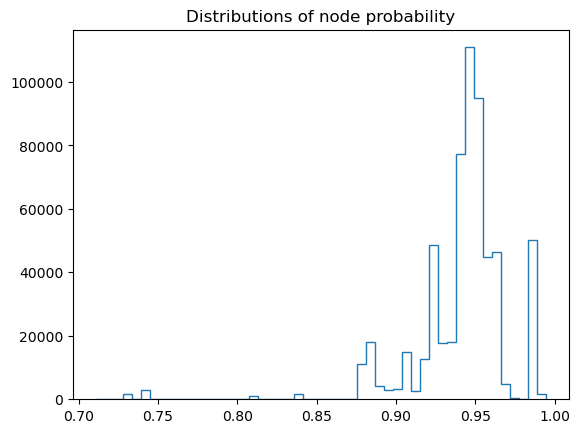

In [37]:
hist, edges = np.histogram(prob_df, bins=50)
plt.stairs(hist, edges)
plt.title("Distributions of node probability")

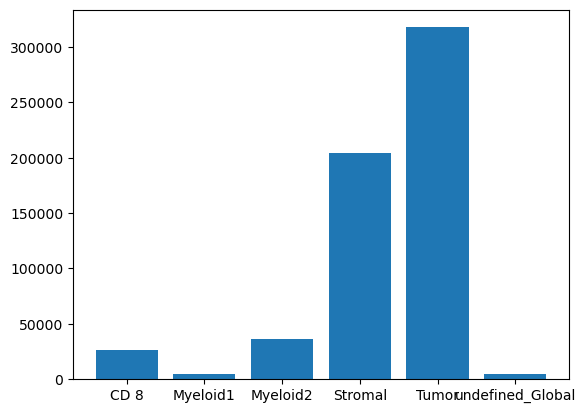

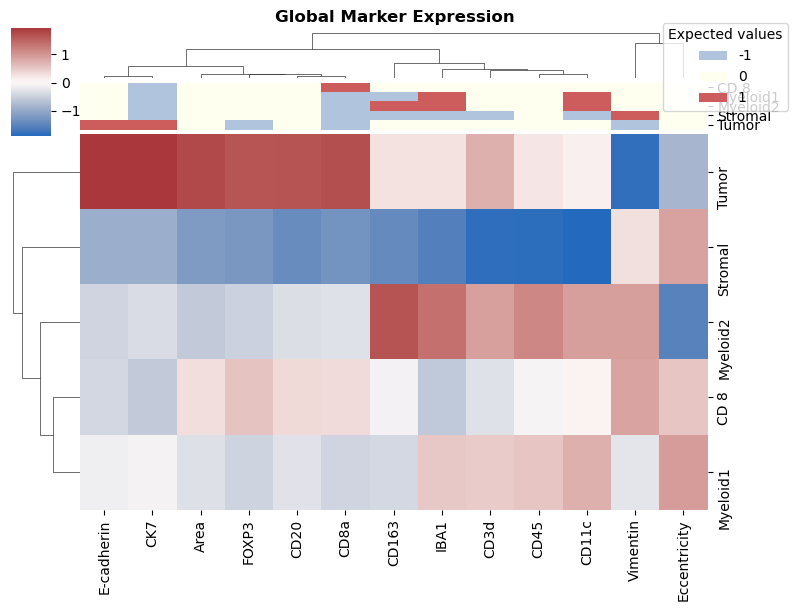

,CD3d,E-cadherin,Vimentin,CK7,CD45,IBA1,CD20,CD8a,CD163,FOXP3,Eccentricity,Area,CD11c
CD 8,-0.304598,-0.419770,0.872865,-0.564088,-0.078236,-0.578885,0.348418,0.331628,-0.099304,0.556353,0.537937,0.293830,0.094821
Myeloid1,0.478802,-0.145606,-0.258104,-0.082800,0.539268,0.501732,-0.286757,-0.452265,-0.409620,-0.468446,0.943221,-0.307186,0.750683
Myeloid2,0.899800,-0.446181,0.907563,-0.357995,1.129985,1.372613,-0.331938,-0.291839,1.655658,-0.480141,-1.536022,-0.574304,0.915609
Stromal,-1.819887,-0.924586,0.285042,-0.919159,-1.834868,-1.566964,-1.389602,-1.296299,-1.417064,-1.246723,0.881859,-1.175320,-1.890107
Tumor,0.745883,1.936144,-1.807365,1.924041,0.243851,0.271505,1.659879,1.708776,0.270330,1.638956,-0.826995,1.762980,0.128995


In [38]:
cell_type_distribution(labels_df, level="Global")

heatmap_for_median_expression(sample_data, labels_df, logic, level="Global", save=False, fname=None,
                                dpi='figure', transform=z_score, title="{} Marker Expression".format(level),
                                c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                cmap_='vlag', dendrogram_ratio_=0.1)